Loading Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.model_selection import train_test_split
sns.set_style('whitegrid')
import os,zipfile
from keras.optimizers import RMSprop
from keras.utils import to_categorical
import itertools
from sklearn.metrics import confusion_matrix

Unzipping the files

In [ ]:
zip_file=['train.csv','test.csv']
for file in zip_file:
  with zipfile.ZipFile('/content/drive/MyDrive/{}.zip'.format(file),'r') as z:
    z.extractall('.')
    print('{} extracted'.format(file))


train.csv extracted
test.csv extracted


In [ ]:
'''!pip uninstall keras -y
!pip uninstall tensorflow -y
!pip install keras==2.3.1
!pip install tensorflow==2.2.0'''

Uninstalling Keras-2.3.1:
  Successfully uninstalled Keras-2.3.1
^C
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/cli/base_command.py", line 153, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/uninstall.py", line 79, in run
    auto_confirm=options.yes, verbose=self.verbosity > 0,
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/req/req_install.py", line 754, in uninstall
    uninstalled_pathset = UninstallPathSet.from_dist(dist)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/req/req_uninstall.py", line 536, in from_dist
    paths_to_remove.add(path)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/req/req_uninstall.py", line 346, in add
    path = os.path.join(normalize_path(head), os.path.normcase(tail))
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/utils/misc.py", line 314, in no

In [ ]:
import keras
print(keras.__version__)

2.3.1


Seggregating the data into images and labels

In [ ]:
path='/content/'
train_csv=os.path.join(path,'train.csv')
test_csv=os.path.join(path,'test.csv')
train=pd.read_csv(train_csv)
test=pd.read_csv(test_csv)


Getting the feel of the data

In [ ]:
print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


In [ ]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
IMG_WIDTH=28
IMG_HEIGHT=28
NO_OF_CHANNELS=1
IMG_DIM=(IMG_WIDTH,IMG_HEIGHT,NO_OF_CHANNELS)

Lets split the data into features and labels.<br>
We will standardize the data by dividing 255 since we want all pixel intensities to be in range[0,1]

In [ ]:
X_train=train.iloc[:,1:].values.reshape(train.shape[0],IMG_WIDTH,IMG_HEIGHT).astype('float32')
X_train=X_train/255
y_train=train.iloc[:,0].values.reshape(train.shape[0]).astype('int32')
X_test=test.iloc[:,0:].values.reshape(test.shape[0],IMG_WIDTH,IMG_HEIGHT).astype('float32')
X_test=X_test/255


Lets check the shape after transformation

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)


(42000, 28, 28)
(28000, 28, 28)
(42000,)


Lets check the distribution of label

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Class Distribution')

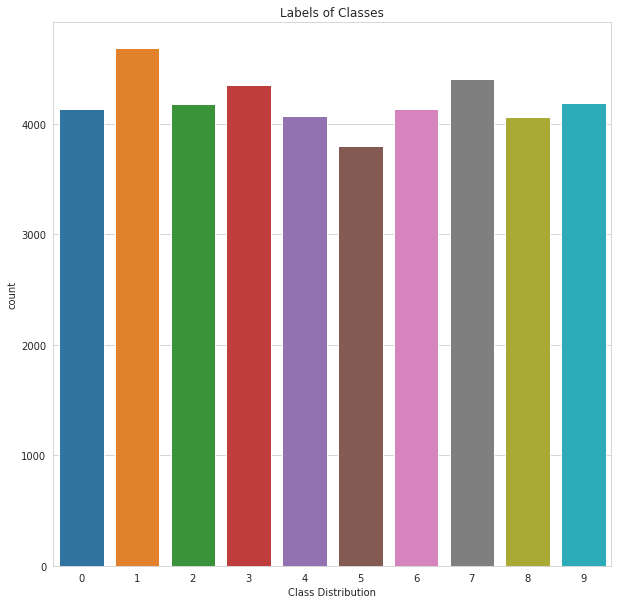

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y_train)
plt.title('Labels of Classes')
plt.xlabel('Class Distribution')

Getting the hang of some images

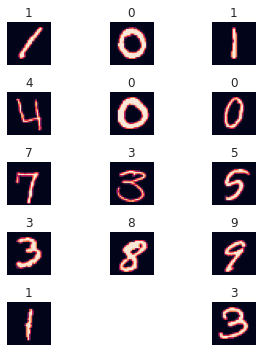

In [ ]:
plt.figure(figsize=(5,5))
for i in range(0,15):
  plt.subplot(5,3,i+1)
  plt.imshow(X_train[i])
  plt.title(y_train[i])
  plt.axis('Off')
  plt.tight_layout()

Reshaping the images into 3d tensors and standardizing the data

In [ ]:
X_train=X_train.reshape(X_train.shape[0],IMG_WIDTH,IMG_HEIGHT,NO_OF_CHANNELS).astype(np.float32)
X_test=X_test.reshape(X_test.shape[0],IMG_WIDTH,IMG_HEIGHT,NO_OF_CHANNELS).astype(np.float32)
print(X_train.shape)
print(X_test.shape)


(42000, 28, 28, 1)
(28000, 28, 28, 1)


Encoding the labels.<br>
Since we are doing multiclass classification here we will be using OneHot Encoding to encode the labels.<br>
OneHot Encoding will mark the particular label value with 1 and rest as zero.<br>
for e.g in labels 0 to 9 if the particular label is 2,<br>it will be read as [0010000000]


In [ ]:
y_train=to_categorical(y_train,num_classes=10).astype('int32')
print('There are {} classes in y_train'.format(y_train.shape[1]))
print('The shape of ytrain is {}'.format(y_train.shape))

There are 10 classes in y_train
The shape of ytrain is (42000, 10)


Modelling the data
We will be training the dataset using Convolutional Neural Network comprising 3 layers

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))
model.compile(optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 64)         

Setting the Callbacks


In [ ]:
reduce_lr_on_plateau=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,min_lr=0.00001)


Splitting the data on training and validation data

In [ ]:
seed=42
random_state=np.random.seed(seed)
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.2,random_state=random_state)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(26880, 28, 28, 1)
(26880, 10)
(6720, 28, 28, 1)
(6720, 10)


In [ ]:
batch_size=64
epochs=20
#training_data=X_train,y_train
#validation_data=X_val,y_val

Augmenting the Images

In [ ]:
train_gen=ImageDataGenerator(zca_epsilon=1e-06,rotation_range=10,width_shift_range=0.08,height_shift_range=0.8,shear_range=0.3,zoom_range=0.1)
#train_generator=train_gen.flow(X_train,y_train,batch_size=batch_size)
train_gen.fit(X_train)


In [ ]:
history=model.fit_generator(train_gen.flow(X_train,y_train,batch_size=batch_size),epochs=epochs,
                            steps_per_epoch=X_train.shape[0]//batch_size,
                            validation_data=(X_val,y_val),validation_steps=X_val.shape[0]//batch_size,
                            callbacks=[reduce_lr_on_plateau])

Epoch 1/20
336/336 [==============================] - 7s 22ms/step - loss: 0.5822 - accuracy: 0.7945 - val_loss: 0.0478 - val_accuracy: 0.9870
Epoch 2/20
336/336 [==============================] - 7s 21ms/step - loss: 0.5794 - accuracy: 0.7969 - val_loss: 0.0461 - val_accuracy: 0.9870
Epoch 3/20
336/336 [==============================] - 7s 21ms/step - loss: 0.5852 - accuracy: 0.7961 - val_loss: 0.0504 - val_accuracy: 0.9872
Epoch 4/20
336/336 [==============================] - 7s 22ms/step - loss: 0.5861 - accuracy: 0.7975 - val_loss: 0.0401 - val_accuracy: 0.9872
Epoch 5/20
336/336 [==============================] - 7s 22ms/step - loss: 0.5852 - accuracy: 0.7931 - val_loss: 0.0686 - val_accuracy: 0.9825
Epoch 6/20
336/336 [==============================] - 7s 21ms/step - loss: 0.5810 - accuracy: 0.7983 - val_loss: 0.0481 - val_accuracy: 0.9860

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/20
336/336 [==============================] - 7s 22m

Lets plot the curves

In [ ]:
history_dict=history.history
history_dict.keys()


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])

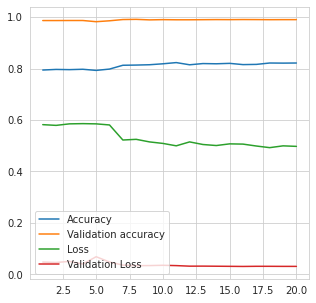

In [ ]:
plt.figure(figsize=(5,5))
accuracy=history_dict['accuracy']
val_accuracy=history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']
epochs=range(1,len(accuracy)+1)
plt.plot(epochs,accuracy,label='Accuracy')
plt.plot(epochs,val_accuracy,label='Validation accuracy')
plt.plot(epochs,loss,label='Loss')
plt.plot(epochs,val_loss,label='Validation Loss')
plt.legend()
plt.show()

Confusion Matrix-Lets plot the confusion matrix

In [ ]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion Matrix',cmap=plt.cm.Blues):
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=45)
  plt.yticks(tick_marks,classes)
  if normalize:
    cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
  thresh=cm.max()/2
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,cm[i,j],horizontalalignment='center',color='white' if cm[i,j]>thresh else 'black')
  plt.tight_layout()
  plt.ylabel('Predicted Label')
  plt.xlabel('Actual Label')





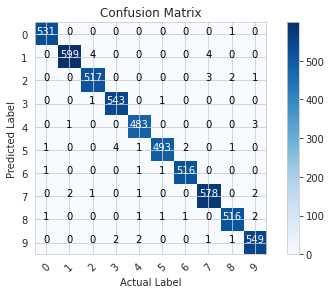

In [ ]:
y_pred=model.predict(X_val)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_val,axis=1)
confusion_mtx=confusion_matrix(y_true,y_pred_classes)
plot_confusion_matrix(confusion_mtx,classes=range(10))

Lets do final Predictions

In [ ]:
predict=model.predict(X_test)
predictions=np.argmax(predict,axis=1)
Predictions=pd.DataFrame()
Predictions['ImageId']=range(1,28001)
Predictions['Label']=predictions
Predictions.to_csv('Predictions.csv',index=False,header=True)
